In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

!pip install git+git://github.com/VIDA-NYU/openclean.git

  Cloning git://github.com/VIDA-NYU/openclean.git to /tmp/pip-req-build-gm6iidaq
  Running command git clone -q git://github.com/VIDA-NYU/openclean.git /tmp/pip-req-build-gm6iidaq
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 276kB 3.9MB/s 
     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 235kB 6.7MB/s 
     |████████████████████████████████| 92kB 5.0MB/s 
     |████████████████████████████████| 112kB 8.2MB/s 
     |████████████████████████████████| 532kB 8.0MB/s 
     |████████████████████████████████| 645kB 13.6MB/s 
     |████████████████████████████████| 163kB 16.8MB/s 
     |████████████████████████████████| 153kB 16.2MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
  Created wheel for openclean: filename=openclean-0.1.0-cp37-none-any.whl size=5180 sha256=33fe090b824629a44dfb6d6111320969502bd493872a75a2510aad51a11c3196
  Stored in directory: /tmp/pip-ephem-wheel-cache-afh

## Import data

In [2]:
# Initialize dataframe with MTA data file from 05/01/2021
mta_df = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_210501.txt")

In [3]:
## Read in rest of MTA data, dating back to 01/02/2020 (earliest date in COVID database)

# Set start and end dates
start_date = datetime(2020, 1, 2)
end_date = datetime(2021, 4, 30)

# Iterate over files in MTA database
for i in range(int((end_date - start_date).days)):
  curr_date = end_date - timedelta(i)
  
  try:
    # Read in current data file
    curr_df = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt".format(curr_date.strftime("%y%m%d")))
  except:
    continue
  
  # Concatenate data files
  mta_df = pd.concat([mta_df, curr_df], axis=0)

## Preliminary data profiling & cleaning

In [4]:
# Check rows
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/24/2021,00:00:00,REGULAR,7561288,2582898
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/24/2021,04:00:00,REGULAR,7561295,2582903
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/24/2021,08:00:00,REGULAR,7561302,2582918
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/24/2021,12:00:00,REGULAR,7561336,2582977
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/24/2021,16:00:00,REGULAR,7561426,2583008


In [5]:
# Check info
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14586465 entries, 0 to 206498
Data columns (total 11 columns):
 #   Column                                                                Dtype 
---  ------                                                                ----- 
 0   C/A                                                                   object
 1   UNIT                                                                  object
 2   SCP                                                                   object
 3   STATION                                                               object
 4   LINENAME                                                              object
 5   DIVISION                                                              object
 6   DATE                                                                  object
 7   TIME                                                                  object
 8   DESC                                                          

In [6]:
## Fix formatting issues

# Convert column names to lowercase & strip whitespace
mta_df.rename(columns=lambda x: x.lower().rstrip(), inplace=True)

# Reset index values
mta_df = mta_df.reset_index(drop=True)

# Convert date column to datetime
mta_df['date'] = pd.to_datetime(mta_df['date'], format="%m/%d/%Y")

In [7]:
# Confirm formatting changes
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14586465 entries, 0 to 14586464
Data columns (total 11 columns):
 #   Column    Dtype         
---  ------    -----         
 0   c/a       object        
 1   unit      object        
 2   scp       object        
 3   station   object        
 4   linename  object        
 5   division  object        
 6   date      datetime64[ns]
 7   time      object        
 8   desc      object        
 9   entries   int64         
 10  exits     int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 1.2+ GB


In [8]:
# Extract min date
mta_df['date'].min()

Timestamp('2019-12-28 00:00:00')

In [9]:
# Remove records whose dates go back too far
mta_df = mta_df[mta_df['date'] >= datetime(2020, 1, 2)]

# Confirm proper min date
mta_df['date'].min()

Timestamp('2020-01-02 00:00:00')

In [10]:
# Inspect station names
stations = mta_df['station'].value_counts()

pd.set_option('max_rows', None)
print(stations)
print("\nThere are {} unique station names in this list".format(len(stations)))

34 ST-PENN STA     292455
FULTON ST          280302
GRD CNTRL-42 ST    236647
23 ST              212284
86 ST              187017
CANAL ST           168434
CHAMBERS ST        159540
34 ST-HERALD SQ    157738
59 ST              150750
42 ST-PORT AUTH    148207
14 ST              148133
ATL AV-BARCLAY     146250
WALL ST            144396
TIMES SQ-42 ST     127953
PATH NEW WTC       124436
125 ST             124229
59 ST COLUMBUS     119617
14 ST-UNION SQ     119399
CORTLANDT ST       113207
28 ST              112766
JAY ST-METROTEC    110181
96 ST              107758
CHURCH AV          107745
161/YANKEE STAD    107561
47-50 STS ROCK     105603
50 ST              104774
METS-WILLETS PT    103468
WTC-CORTLANDT      101814
LEXINGTON AV/53     93179
KINGS HWY           87174
34 ST-HUDSON YD     86679
BOWLING GREEN       84652
72 ST               84472
JAMAICA 179 ST      83046
BOROUGH HALL        79647
FLUSHING-MAIN       75651
8 AV                75236
ST. GEORGE          74706
HARRISON    

In [11]:
# `entries` and `exits` columns are cumulative counts --> compute daily traffic by turnstile
daily_entries_by_turnstile = mta_df.groupby(['c/a', 'unit', 'scp', 'station', 'linename', 'date']).max('entries') - mta_df.groupby(['c/a', 'unit', 'scp', 'station', 'linename', 'date']).min('entries')
daily_exits_by_turnstile = mta_df.groupby(['c/a', 'unit', 'scp', 'station', 'linename', 'date']).max('exits') - mta_df.groupby(['c/a', 'unit', 'scp', 'station', 'linename', 'date']).min('exits')

# Reset indices for merge operation
daily_entries_by_turnstile.reset_index(inplace=True)
daily_exits_by_turnstile.reset_index(inplace=True)

# Merge & group by station, linename, date for daily count by station
daily_traffic_df = pd.merge(daily_entries_by_turnstile, daily_exits_by_turnstile, how='outer').groupby(['station', 'linename', 'date']).sum().reset_index()

In [12]:
# Check daily_traffic_df info
daily_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231714 entries, 0 to 231713
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   station   231714 non-null  object        
 1   linename  231714 non-null  object        
 2   date      231714 non-null  datetime64[ns]
 3   entries   231714 non-null  int64         
 4   exits     231714 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 8.8+ MB


In [13]:
# Analyze unique combinations of subway stations and trainlines
station_line_combos = daily_traffic_df.value_counts(subset=['station', 'linename']).sort_index()

print(station_line_combos)
print("\nThere are {} unique combinations of stations and trainlines in this list".format(len(station_line_combos)))

station          linename    
1 AV             L               485
103 ST           1               485
                 6               485
                 BC              485
103 ST-CORONA    7               485
104 ST           A               485
                 JZ              485
110 ST           6               485
111 ST           7               485
                 A               485
                 J               485
116 ST           23              485
                 6               485
                 BC              485
116 ST-COLUMBIA  1               483
121 ST           JZ              485
125 ST           1               485
                 23              485
                 456             485
                 ACBD            485
135 ST           23              485
                 BC              485
137 ST CITY COL  1               485
138/GRAND CONC   45              485
14 ST            123FLM          485
                 ACEL            485
        

## Data profiling & cleaning with OpenClean

In [14]:
from openclean.pipeline import stream
from openclean.profiling.column import DefaultColumnProfiler
from openclean.profiling.anomalies.sklearn import DBSCANOutliers

In [15]:
# Create openclean data stream
ds = stream(daily_traffic_df)

# Check rows
ds.head()

,station,linename,date,entries,exits
0,1 AV,L,2020-01-02 00:00:00,15135,17646
1,1 AV,L,2020-01-03 00:00:00,15611,18266
2,1 AV,L,2020-01-04 00:00:00,6015,7119
3,1 AV,L,2020-01-05 00:00:00,4724,5530
4,1 AV,L,2020-01-06 00:00:00,16263,18641
5,1 AV,L,2020-01-07 00:00:00,16612,19372
6,1 AV,L,2020-01-08 00:00:00,17206,20275
7,1 AV,L,2020-01-09 00:00:00,17463,20072
8,1 AV,L,2020-01-10 00:00:00,17642,20489
9,1 AV,L,2020-01-11 00:00:00,6971,8220


In [16]:
# Profile a sample of 10000 rows from dataset
profile = ds.sample(n=10000, random_state=42).profile(default_profiler=DefaultColumnProfiler)

# Print profiling statistics
profile.stats()

,total,empty,distinct,uniqueness,entropy
station,10000,0,379,0.0379,8.412974
linename,10000,0,114,0.0114,5.742340
date,10000,0,485,0.0485,8.883511
entries,10000,0,5141,0.5141,12.022901
exits,10000,0,5022,0.5022,11.985223


In [17]:
# Search for `entries` value outliers
DBSCANOutliers(eps=0.02).find(ds.distinct('entries'))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1111,
 11111,
 419073952,
 1313111,
 1506677570,
 316989274,
 631052148,
 475740000,
 1666828816,
 522255]

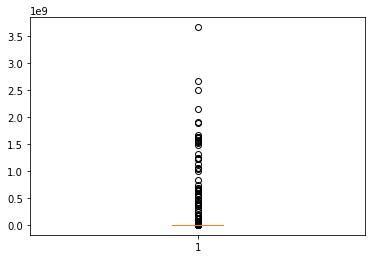

In [18]:
# Visualize `entries` values
plt.boxplot(daily_traffic_df['entries'])
plt.show()

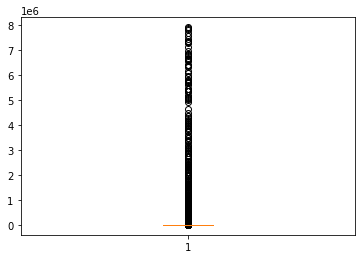

In [19]:
# 8 million people in NYC -> unlikely all of them pass through a single station on a single day. Set 8M as upper bound
daily_traffic_df = daily_traffic_df[daily_traffic_df['entries'] <= 8000000]

# Refresh data stream
ds = stream(daily_traffic_df)

# Re-visualize `entries` values
plt.boxplot(daily_traffic_df['entries'])
plt.show()

In [20]:
# Search for remaining `entries` value outliers
DBSCANOutliers().find(ds.distinct('entries'))

[0]

In [21]:
# Search for `exits` value outliers
DBSCANOutliers(eps=0.02).find(ds.distinct('exits'))

[0,
 1,
 2,
 3,
 11,
 15598391,
 1111,
 12267122,
 1070316087,
 25903656,
 3133737,
 3232633,
 10880811,
 17107630,
 1118551,
 1056966762,
 2024424,
 536872013,
 285180608,
 17134387,
 15498521,
 16743726]

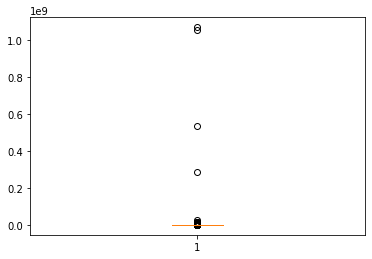

In [22]:
# Visualize `exits` values
plt.boxplot(daily_traffic_df['exits'])
plt.show()

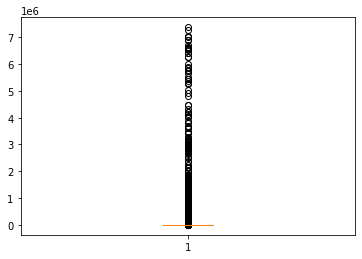

In [23]:
# Again, set 8M as upper bound
daily_traffic_df = daily_traffic_df[daily_traffic_df['exits'] <= 8000000]

# Refresh data stream
ds = stream(daily_traffic_df)

# Re-visualize `exits` values
plt.boxplot(daily_traffic_df['exits'])
plt.show()

In [24]:
# Search for remaining `exits` value outliers
DBSCANOutliers().find(ds.distinct('exits'))

[0]

In [25]:
# Check info
daily_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231565 entries, 0 to 231713
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   station   231565 non-null  object        
 1   linename  231565 non-null  object        
 2   date      231565 non-null  datetime64[ns]
 3   entries   231565 non-null  int64         
 4   exits     231565 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 10.6+ MB


In [26]:
# Define function to concatenate stations and linenames for cluster search
def concat_vals(x):
  return "{}-{}".format(x['station'], x['linename']).strip().replace(" ", "")

# Concatenate stations and linenames to compute clusters
daily_traffic_df['concat'] = daily_traffic_df.apply(concat_vals, axis=1)

# Refresh data stream
ds = stream(daily_traffic_df)

In [27]:
from openclean.cluster.key import KeyCollision
from openclean.function.value.key.fingerprint import Fingerprint

# Isolate concat column
concats = ds.select('concat')

# Cluster concat column
concat_clusters = concats.cluster(clusterer=KeyCollision(func=Fingerprint(), threads=3))

In [28]:
# Define helper method to print k largest clusters
def print_k_clusters(clusters, k=10):
    clusters = sorted(clusters, key=lambda x: len(x), reverse=True)
    val_count = sum([len(c) for c in clusters])
    print('Total number of clusters is {} with {} values'.format(len(clusters), val_count))
    for i in range(min(k, len(clusters))):
        print('\nCluster {}'.format(i + 1))
        for key, cnt in clusters[i].items():
            if key == '':
                key = "''"
            print('  {} (x {})'.format(key, cnt))

In [29]:
# Print 10 largest clusters in concats
print_k_clusters(concat_clusters)

Total number of clusters is 0 with 0 values


In [30]:
# Isolate linename column
linenames = ds.select('linename')

# Cluster linename column
line_clusters = linenames.cluster(clusterer=KeyCollision(func=Fingerprint(), threads=3))

# Print largest clusters
print_k_clusters(line_clusters)

Total number of clusters is 0 with 0 values


In [31]:
## Clustering algorithm failed to identify linename typos -> manually correct errors with lookup table

# Define function to fix linename errors
def fix_linename(x):

  # Define lookup table to fix duplicate values
  duplicate_mapping_dict = {
      '14 ST': {0: 'FLM123', 1: '123FLM'},
      '14 ST-UNION SQ': {0: 'LNQR456W', 1: '456LNQRW'},
      '161/YANKEE STAD': {0: 'BD4', 1: '4BD'},
      '168 ST': {0: 'AC1', 1: '1AC'},
      '42 ST-PORT AUTH': {0: 'ACENGRS1237W', 1: 'ACENQRS1237W'},
      '59 ST COLUMBUS': {0: 'ABCD1', 1: '1ABCD'},
      'ATL AV-BARCLAY': {0: 'BDNQR2345', 1: '2345BDNQR'},
      'BOROUGH HALL': {0: 'R2345', 1: '2345R'},
      'FULTON ST': {0: 'ACJZ2345', 1: '2345ACJZ'}
  }

  # Define lookup table to fix triplicate values
  triplicate_mapping_dict = {
      '34 ST-PENN STA': {0: '123', 1: 'ACE', 2: '123ACE'},
      '59 ST': {0: 'NQR456W', 1: 'NRW', 2: '456NQRW'},
      'TIMES SQ-42 ST': {0: '1237ACENQRS', 1: 'ACENQRS1237W', 2: '1237ACENQRSW'}
  }

  curr_station = x['station']
  curr_line = x['linename']

  # Fix duplicates
  if curr_station in duplicate_mapping_dict:
    if curr_line == duplicate_mapping_dict[curr_station][0]:
      return duplicate_mapping_dict[curr_station][1]
    else:
      return curr_line
  
  # Fix triplicates
  elif curr_station in triplicate_mapping_dict:
    if curr_line == triplicate_mapping_dict[curr_station][0] or curr_line == triplicate_mapping_dict[curr_station][1]:
      return triplicate_mapping_dict[curr_station][2]
    else:
      return curr_line
  
  else:
    return curr_line

In [32]:
# Fix linenames
daily_traffic_df['linename'] = daily_traffic_df.apply(fix_linename, axis=1)

In [33]:
# Analyze corrected subway station and trainline combos
station_line_values = daily_traffic_df.value_counts(subset=['station', 'linename']).sort_index()

print(station_line_values)
print("\nThere are {} unique combinations of stations and trainlines in this list".format(len(station_line_values)))

station          linename    
1 AV             L                485
103 ST           1                485
                 6                485
                 BC               485
103 ST-CORONA    7                485
104 ST           A                485
                 JZ               485
110 ST           6                485
111 ST           7                485
                 A                485
                 J                485
116 ST           23               485
                 6                485
                 BC               484
116 ST-COLUMBIA  1                483
121 ST           JZ               485
125 ST           1                485
                 23               485
                 456              483
                 ACBD             484
135 ST           23               484
                 BC               485
137 ST CITY COL  1                485
138/GRAND CONC   45               485
14 ST            123FLM           969
                 ACE

In [34]:
# Drop concat column
daily_traffic_df = daily_traffic_df.drop('concat', axis=1)

# Check info
daily_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231565 entries, 0 to 231713
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   station   231565 non-null  object        
 1   linename  231565 non-null  object        
 2   date      231565 non-null  datetime64[ns]
 3   entries   231565 non-null  int64         
 4   exits     231565 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 10.6+ MB


## Visulaizations

In [35]:
# Group by date for time-series analysis
total_daily_traffic_df = daily_traffic_df.groupby('date').sum().reset_index()

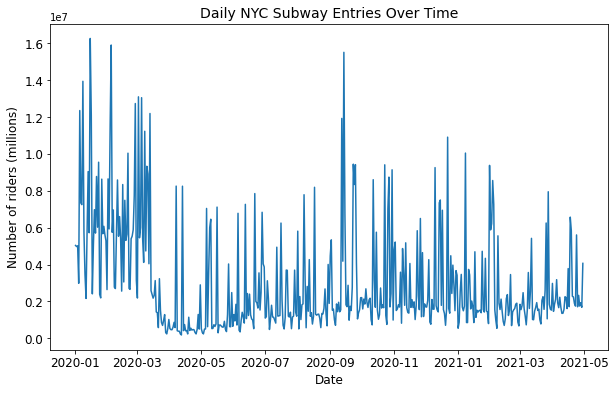

In [36]:
# Plot entries over time
plt.figure(figsize=(10, 6))

plt.plot('date', 'entries', data=total_daily_traffic_df)
plt.title("Daily NYC Subway Entries Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of riders (millions)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

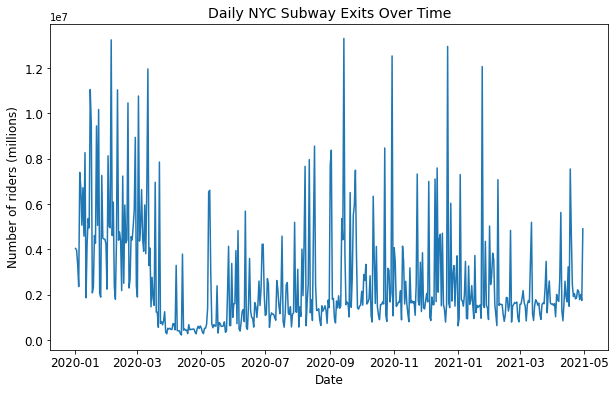

In [37]:
# Plot exits over time
plt.figure(figsize=(10, 6))

plt.plot('date', 'exits', data=total_daily_traffic_df)
plt.title("Daily NYC Subway Exits Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of riders (millions)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [38]:
# Compute average daily ridership for each station by quarter
avg_monthly_traffic_by_station = daily_traffic_df.groupby(['station', pd.Grouper(key='date', freq='1Q')]).mean().reset_index()

<IPython.core.display.Javascript object>

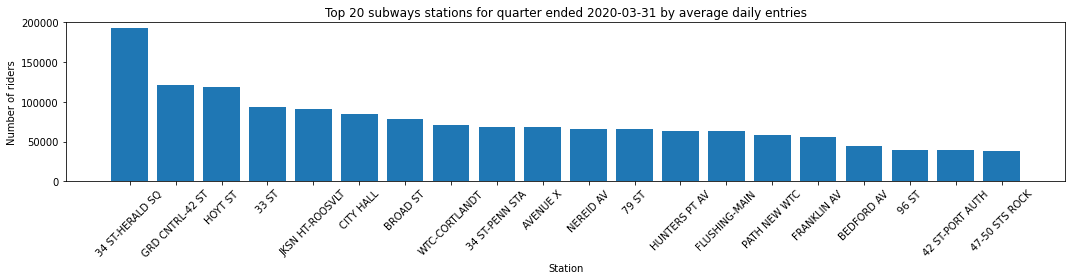

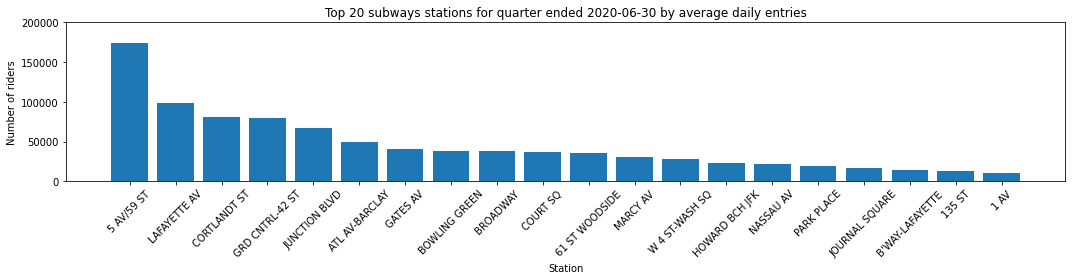

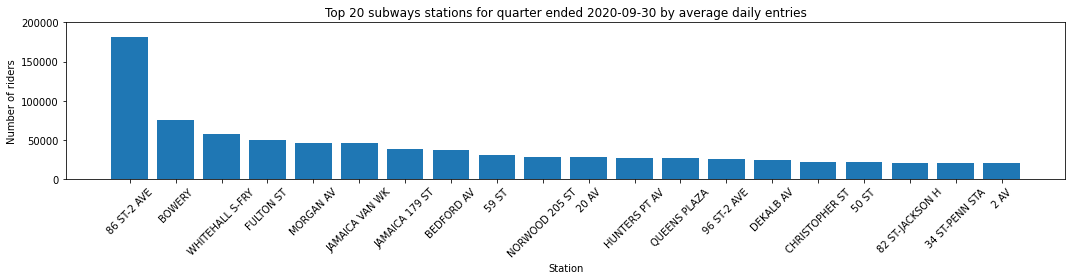

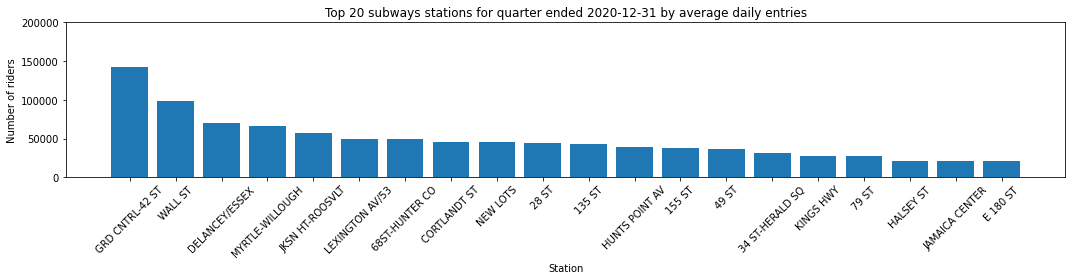

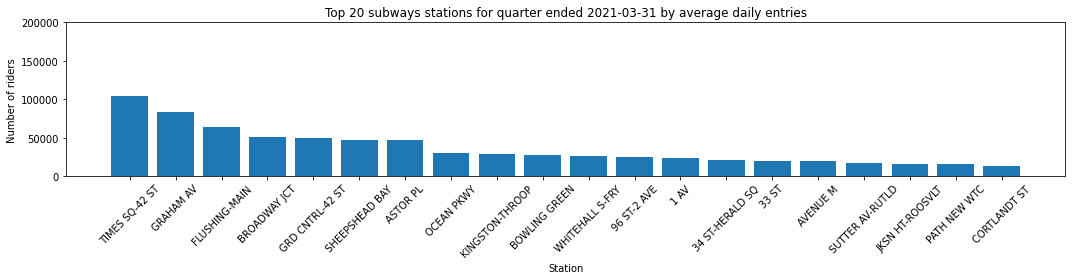

In [39]:
## Plot top 20 stations by entries for each quarter

# Increase size of out cell
from IPython.display import Javascript
display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))

# Create list of quarter-end dates
dates = ['2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31']

# Plot top 20 stations by entries for each quarter
for date in dates:
  monthly_top_20 = avg_monthly_traffic_by_station[avg_monthly_traffic_by_station.date == date].sort_values('entries', ascending=False).head(20)

  # Plot top 20 stations
  plt.figure(figsize=(15, 4))
  plt.bar(x='station', height='entries', data=monthly_top_20)

  plt.title('Top 20 subways stations for quarter ended {} by average daily entries'.format(date))
  plt.xlabel('Station')
  plt.xticks(rotation=45)
  plt.ylabel('Number of riders')
  plt.ylim(top=200000)
  plt.tight_layout()

<IPython.core.display.Javascript object>

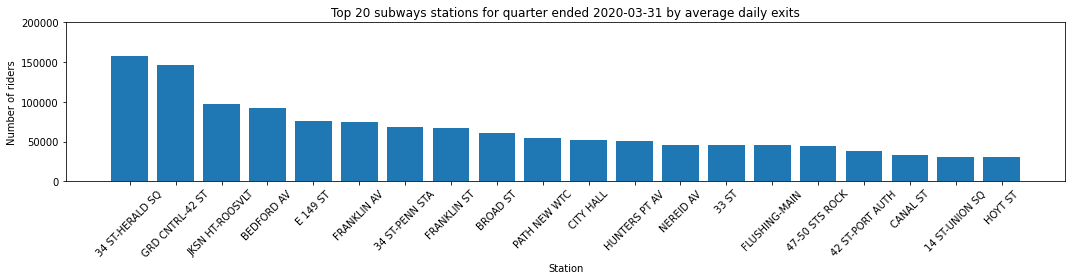

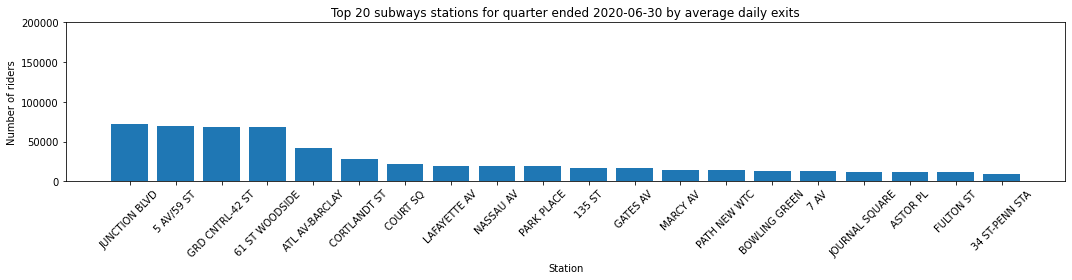

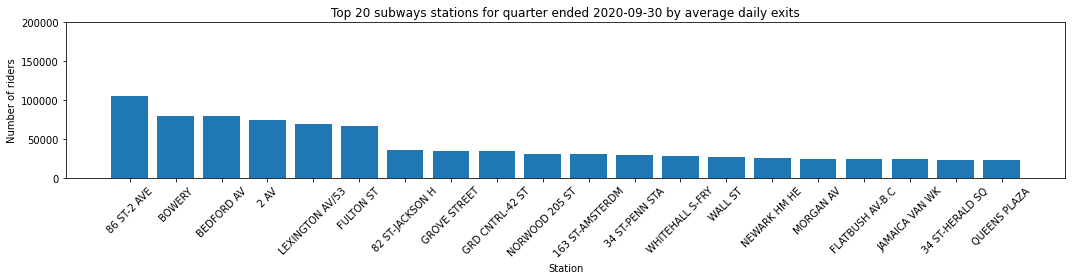

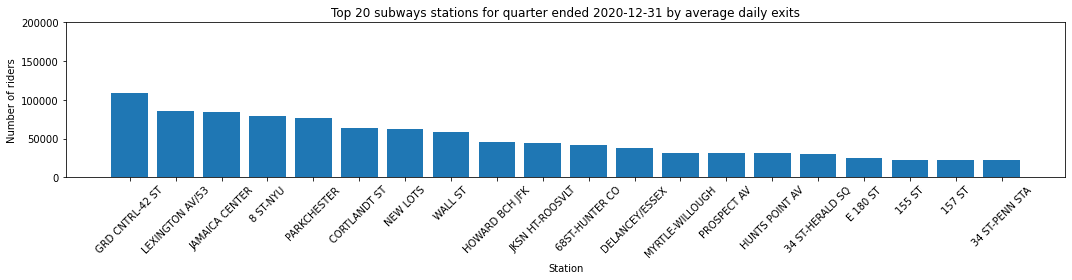

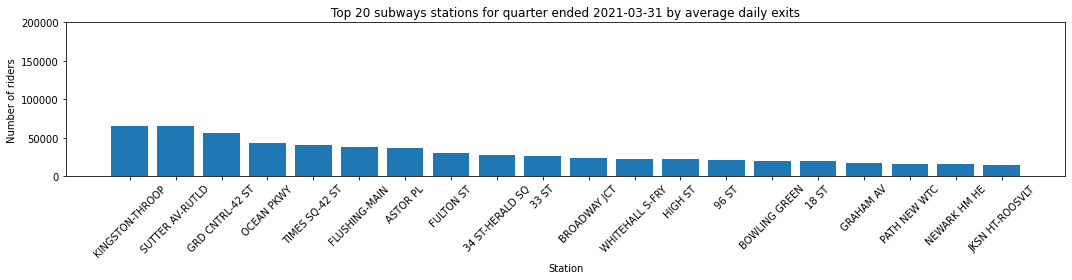

In [40]:
## Plot top 20 stations for each quarter

# Increase size of out cell
from IPython.display import Javascript
display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))

# Create list of quarter-end dates
dates = ['2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31']

# Plot top 20 stations for each quarter
for date in dates:
  monthly_top_20 = avg_monthly_traffic_by_station[avg_monthly_traffic_by_station.date == date].sort_values('exits', ascending=False).head(20)

  # Plot top 20 stations
  plt.figure(figsize=(15, 4))
  plt.bar(x='station', height='exits', data=monthly_top_20)

  plt.title('Top 20 subways stations for quarter ended {} by average daily exits'.format(date))
  plt.xlabel('Station')
  plt.xticks(rotation=45)
  plt.ylabel('Number of riders')
  plt.ylim(top=200000)
  plt.tight_layout()